# Диплом 2024

### Содержание:
- [Установка необходимых пакетов, если они не установлены](#inst_)
- [Импорт библиотек](#libr_)
- [Загрузка датасетов](#load_data_)
  - [Описание данных](#description)
- [Разведочный анализ даных (EDA)](#eda_)
  - [Посмотрим типы данных](#dtypes_)
  - [Посмотрим пропуски данных](#pass_)
  - [Посмотри статистику по датафрейму](#statistics_)
  - [Визуализируем данные](#visual_)
    - [Выделим численные признаки от даты](#num_and_char_)
    - [Создадим словарь признаков и пояснения](#translate_)
    - [Визуализируем распределение числовых признаков](#num_visual)
    - [Визуализируем распределение строковых признаков](#char_visual)
- [Предобработка признаков](#predobrabotka)
  - [Посмотрим какие признаки имеют выбросы](#vibros)
  - [Признак 'HouseYear'](#house_year)
  - [Признак 'Rooms'](#rooms)
  - [Признак 'KitchenSquare'](#kitchen_square)
  - [Признаки 'Square' и 'LifeSquare'](#square_life_square)
  - [Признаки 'HouseFloor' и 'Floor'](#floor_house_floor)
  - [Признак 'Healthcare_1'](#healthcare_1)
  - [Изменим тип признаков](#type_f)
  - [Ещё раз посмотрим скорректированные данные](#cor_data)
- [Создание класса подготовки данных](#create_class)
- [Построение новых признаков](#new_feature)
  - [DistrictSize, IsDistrictLarge (размеры районов)](#district_size)
  - [MedPriceDistrict (медиана цены квартиры в зависимости от района и количества комнат)](#med_price_district)
  - [MedPriceByFloorYear (средняя цена квартиры в зависимости от этажа и года постройки дома)](#med_price_by_floor_year)
- [Создание класса новых признаков](#create_class_2)
- [Создание модели](#create_model)
  - [Проверим модель без генерации новых фич](#model_1)
  - [Проверим модель с генерацией новых фич](#model_2)
- [Прогнозирование на тестовом датасете](#prognoz)
- [Вывод](#vivod)

### Установка пакетов если они не установлены <a class='anchor' id='inst_'>

In [34]:
# Для кождого проекта я использую новое окружение, 
# думаю это помогает избежать ошибок связанных с версиями пакетов
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install scikit-learn
# !pip install openpyxl

### Импортируем библиотеки <a class='anchor' id='libr_'>

In [35]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Модуль для зазбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Дата и время
from datetime import datetime

# Случайные числа
import random as rnd

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score

# Пути файловой системы
from pathlib import Path

# Регулярные выражения
import re

### Загружаем данные <a class='anchor' id='load_data_'>

Описание данных <a class='anchor' id='description'>
- **Id** - идентификационный номер квартиры;
- **DistrictId** - идентификационный номер района;
- **Rooms** - количество комнат;
- **Square** - площадь;
- **LifeSquare** - жилая площадь;
- **KitchenSquare** - площадь кухни;
- **Floor** - этаж;
- **HouseFloor** - количество этажей в доме;
- **HouseYear** - год постройки дома;
- **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели месности;
- **Social_1**, **Social_2**, **Social_3** - социальные показатели месности;
- **Healtcare_1**, **Heltcare_2** - показатели месности, связанные с охраной здоровья;
- **Shops_1**, **Shops_2** - показатели связанные с наличием магазинов, торговых центров;
- **Price** - цена квартиры.

In [36]:
# Расположение данных
PATH_DATASET = './Dataset'
# Минимальное количество строк в датасете
MIN_ROW = 6000


train_data = pd.DataFrame()

p = Path(Path.cwd() / PATH_DATASET)

for obj in p.iterdir():
    if obj.is_file():
        *_, name_file_all = str(obj).split('\\')
        name_file, type_file = name_file_all.split('.')
        if type_file == 'xlsx':
            df_temp = pd.read_excel(f'{PATH_DATASET}/{name_file_all}')
            # Переименуем стобцы
            df_temp.rename(columns={'Значение': f'{name_file}'}, inplace=True)
            # Нормализуем дату
            df_temp['Дата'] = df_temp['Дата'].dt.normalize()
            if train_data.shape[1]:
                if df_temp.shape[0] >= MIN_ROW:
                    print(f'Обработан {name_file_all} {df_temp.shape}')
                    train_data = pd.merge(train_data, df_temp, on='Дата', how='inner')
                    print(f'Размерность после merge {train_data.shape}')
                else:
                    print(f'Мало строк {name_file_all}')
            else:
                train_data = df_temp

Обработан eur_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 3)
Обработан gbp_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 4)
Обработан jpy_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (7303, 5)
Обработан s-p-500.xlsx (6178, 2)
Размерность после merge (5817, 6)
Обработан usd_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5817, 7)
Мало строк бивалютная-корзина_rub.xlsx
Обработан золото-(банк-россии).xlsx (6034, 2)
Размерность после merge (4951, 8)
Обработан индекс-мосбиржи.xlsx (6130, 2)
Размерность после merge (4849, 9)
Мало строк китайский-юань---российский-рубль-cny_rub-(банк-россии).xlsx
Обработан нефть-brent.xlsx (6514, 2)
Размерность после merge (4849, 10)
Обработан палладий-(банк-россии).xlsx (6838, 2)
Размерность после merge (4849, 11)
Обработан платина-(банк-россии).xlsx (6912, 2)
Размерность после merge (4849, 12)
Обработан ртс.xlsx (6128, 2)
Размерность после merge (4842, 13)
Обработан серебро-(банк-россии).xlsx (6034

In [37]:
# Посмотрим, что загрузилось
train_data.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43


In [38]:
# Посмотрим размер
train_data.shape

(4842, 14)

### Разведочный анализ даных (EDA) <a class='anchor' id='eda_'>

#### Посмотрим типы данных <a class='anchor' id='dtypes_'>

In [39]:
train_data.dtypes

Дата                      datetime64[ns]
chf_rub-(банк-россии)            float64
eur_rub-(банк-россии)            float64
gbp_rub-(банк-россии)            float64
jpy_rub-(банк-россии)            float64
s-p-500                          float64
usd_rub-(банк-россии)            float64
золото-(банк-россии)             float64
индекс-мосбиржи                  float64
нефть-brent                      float64
палладий-(банк-россии)           float64
платина-(банк-россии)            float64
ртс                              float64
серебро-(банк-россии)            float64
dtype: object

#### Посмотрим пропуски данных <a class='anchor' id='pass_'>

In [40]:
# Проверка того, в каких столбцах отсутствуют значения
print(train_data.isnull().sum(axis=0))

Дата                      0
chf_rub-(банк-россии)     0
eur_rub-(банк-россии)     0
gbp_rub-(банк-россии)     0
jpy_rub-(банк-россии)     0
s-p-500                   0
usd_rub-(банк-россии)     0
золото-(банк-россии)      0
индекс-мосбиржи           0
нефть-brent               0
палладий-(банк-россии)    0
платина-(банк-россии)     0
ртс                       0
серебро-(банк-россии)     0
dtype: int64


#### Посмотри статистику по датафрейму <a class='anchor' id='statistics_'>

In [41]:
train_data.describe()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
count,4842,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00,4842.00
mean,2014-01-02 13:36:21.412639232,48.55,56.61,69.02,0.43,2188.03,47.66,2131.57,1835.95,73.48,1656.40,1633.94,1248.14,29.36
min,2003-07-07 00:00:00,20.90,32.95,40.48,0.21,682.55,23.13,333.56,391.93,19.33,144.32,600.37,427.64,4.44
25%,2008-09-24 06:00:00,23.80,37.05,49.89,0.27,1256.26,29.06,714.63,1372.19,54.17,279.26,1188.66,991.46,12.92
50%,2013-12-28 12:00:00,37.15,45.97,54.48,0.39,1804.92,34.35,1668.49,1666.57,70.95,795.39,1648.30,1209.70,30.17
75%,2019-04-01 18:00:00,66.10,73.42,86.01,0.58,2850.82,65.24,2807.79,2306.90,91.78,2782.88,1930.70,1488.71,36.00
max,2024-07-09 00:00:00,115.22,113.26,136.04,0.85,5576.98,103.16,7231.12,4287.52,146.08,8507.40,3396.33,2487.92,92.42
std,NaN,24.83,21.01,22.59,0.16,1174.85,21.14,1585.96,840.20,25.37,1728.92,593.47,401.21,18.67


### Визуализируем данные <a class='anchor' id='visual_'>

#### Выделим численные признаки от даты <a class='anchor' id='num_and_char_'>

In [42]:
# Создадим список численных признаков
num_cols = [column for column in train_data if not column=='Дата']
# Признак даты
date_cols = 'Дата'
num_cols

['chf_rub-(банк-россии)',
 'eur_rub-(банк-россии)',
 'gbp_rub-(банк-россии)',
 'jpy_rub-(банк-россии)',
 's-p-500',
 'usd_rub-(банк-россии)',
 'золото-(банк-россии)',
 'индекс-мосбиржи',
 'нефть-brent',
 'палладий-(банк-россии)',
 'платина-(банк-россии)',
 'ртс',
 'серебро-(банк-россии)']

#### Создадим словарь признаков и пояснения <a class='anchor' id='translate_'>

In [43]:
# Словарь признаков и их пояснения
explanations_col = {
    'chf_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'eur_rub-(банк-россии)': 'Евро / Российский рубль',
    'gbp_rub-(банк-россии)': 'Британский фунт стерлингов / Российский рубль',
    'jpy_rub-(банк-россии)': 'Японская иена / Российский рубль',
    's-p-500': 'Индекс S&P 500',
    'usd_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'золото-(банк-россии)': '',
    'индекс-мосбиржи': '',
    'нефть-brent': '',
    'палладий-(банк-россии)': '',
    'платина-(банк-россии)': '',
    'ртс': 'Индекс РТС',
    'серебро-(банк-россии)': '',
}

#### Визуализируем распределение числовых признаков <a class='anchor' id='num_visual'>

In [44]:
def visualization_numerical_characteristics(X=train_data, explanations_col=explanations_col, dop_text=''):
    '''
    Визуализация цифровых признаков (так сделал, чтобы код в одном месте находился).

    :param X: датасет, который будем визуализировать,
    :param explanations_col: словарь признаков и их пояснения,
    :param dop_text: добавляется дополнительный текст к заголовку.
    '''
    plt.figure(figsize=[11, 13])

    # Общий заголовок для всех графиков
    plt.suptitle('Распределение числовых признаков '  + dop_text, 
                  y=1.005, 
                  fontsize=19, 
                  fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        explanations = ''
        if not explanations_col[col] is '':
            explanations = f'\n({explanations_col[col]})'
        plt.title(f'\n{col}{explanations}', fontsize=10)
        # Задаём размер шривта и угол поворота текста для осей X и Y
        plt.xticks(fontsize=8, rotation=0)
        plt.yticks(fontsize=8, rotation=0)
        # Делаем размер шрифта по Y=5, не уберая название оси
        plt.ylabel('', fontsize=5)
        # Отрисовываем гистограмму
        plt.hist(X[col])

    # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

    # Вывести графики на экран
    plt.show()

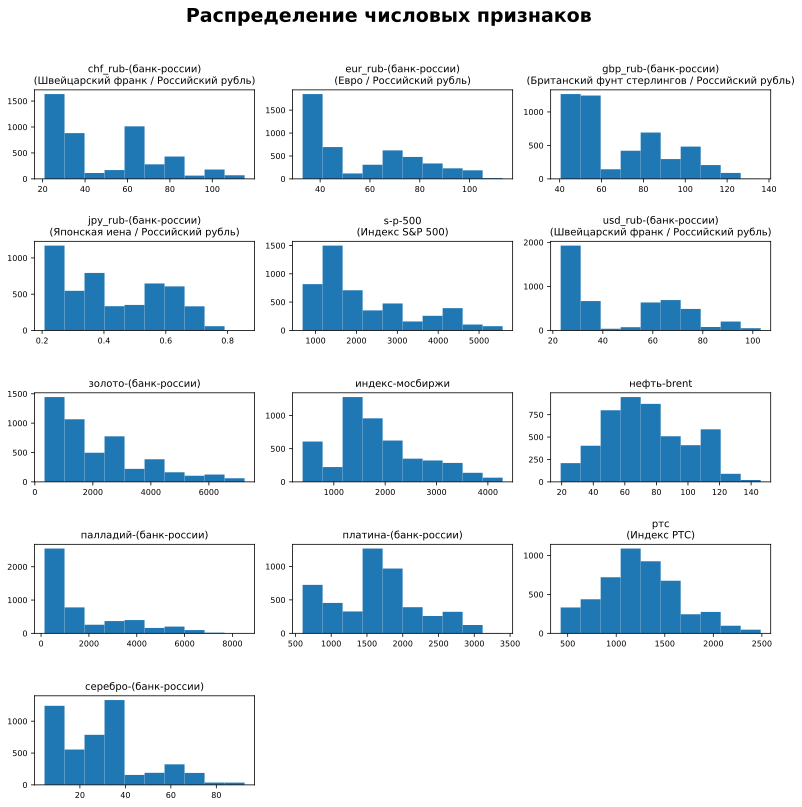

In [45]:
visualization_numerical_characteristics()

### Предобработка признаков <a class='anchor' id='predobrabotka'>

#### Посмотрим какие признаки имеют выбросы <a class='anchor' id='vibros'>

In [46]:
def emission_test(ds, col_test, threshold_val=3, explanations_col=explanations_col):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список колонок,
    :param threshold_val: пороговое значение Z-score,
    :param explanations_col: словарь признаков и их пояснения,
    :return: текстовый отчет и список выбросов.
    '''
    result = ''
    NUM = 2  # количество цифр после запятой
    outliers_list = [] # лист выбросов
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]
        
        if len(outliers) > 0:
            outliers_list.append(outliers)
            
            result += f'В столбце {col} ({explanations_col[col]}),\n{len(outliers)} выбросов. Mean: {round(ds[col].mean(), NUM)}, ' \
            f'Min: {round(ds[col].min(), NUM)}, Max: {round(ds[col].max(), NUM)}, ' \
            f'Moda: {round(ds[col].mode()[0], NUM)}, Median: {round(ds[col].median(), NUM)} \n\n'
    
    return f'Выбросов нет. ' if result == '' else result, outliers_list

In [47]:
def viev_outliers(outliers_list, col_name):
    '''
    Функция выводит строки датафрейма, в которых есть выбросы.
    
    :param outliers_list: список выбросов,
    :param col_name: название признака (фичи),
    :return: индексы выбросов.
    '''
    for item in outliers:
        if item.name == col_name:
            return item.index 

In [48]:
# Выведем признаки которые имеют выбросы
text_outliers, outliers = emission_test(ds=train_data, col_test=num_cols)

In [49]:
# Выведем текстовый отчёт по выбросам
print(text_outliers)

В столбце золото-(банк-россии) (),
23 выбросов. Mean: 2131.57, Min: 333.56, Max: 7231.12, Moda: 5993.16, Median: 1668.5 

В столбце палладий-(банк-россии) (),
22 выбросов. Mean: 1656.4, Min: 144.32, Max: 8507.4, Moda: 3275.71, Median: 795.39 

В столбце ртс (Индекс РТС),
6 выбросов. Mean: 1248.14, Min: 427.64, Max: 2487.92, Moda: 982.94, Median: 1209.7 

В столбце серебро-(банк-россии) (),
23 выбросов. Mean: 29.36, Min: 4.44, Max: 92.42, Moda: 32.11, Median: 30.17 




### Test

In [50]:
# Модуль для работы с временными рядами
from sklearn.model_selection import TimeSeriesSplit

In [51]:
def choice_quarter(month):
    '''
    Функция определения квартала.

    :param month: номер месяца 1-12,
    :return: номер квартала 1-4, или -1, если ошибка.
    '''
    if month <= 3:
        return 1
    elif 4 <= month <= 6:
        return 2
    elif 7 <= month <= 9:    
        return 3
    elif 10 <= month <= 12:    
        return 4
    else:
        return -1

# Создадим дополнительные признаки (год, месяц, день, день недели (Пн-Вс), номер недели, квартал, полугодие)
train_data['Year'] = train_data['Дата'].dt.year
train_data['Month'] = train_data['Дата'].dt.month
train_data['Weekday'] = train_data['Дата'].dt.weekday
train_data['Day'] = train_data['Дата'].dt.day
train_data['Week'] = train_data['Дата'].dt.isocalendar().week
train_data['Halfyear'] = train_data['Дата'].apply(lambda x: 1 if x.month < 7 else 2)
train_data['Quarter'] = train_data['Month'].apply(lambda x: choice_quarter(x))
# Установим столбец даты в качестве индекса
# train_data = train_data.set_index('Дата')

train_data.head()

,Дата,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,...,платина-(банк-россии),ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter
0,2024-07-09,98.46,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,...,2899.89,1093.26,86.68,2024,7,1,9,28,2,3
1,2024-07-08,98.11,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,...,2867.60,1119.25,85.96,2024,7,0,8,28,2,3
2,2024-07-05,97.77,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,...,2835.97,1125.66,85.36,2024,7,4,5,27,2,3
3,2024-07-03,97.33,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,...,2786.57,1147.28,82.73,2024,7,2,3,27,2,3
4,2024-07-02,96.98,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,...,2840.35,1151.82,82.43,2024,7,1,2,27,2,3


In [52]:
# item_mean_year = train_data.groupby(['Year']).agg({'usd_rub-(банк-россии)':'mean'}).rename(columns={'usd_rub-(банк-россии)':'usd-rub-year'})
# item_mean_year

In [53]:
# item_mean_year = item_mean_year['usd-rub-year'].shift(1)
# item_mean_year

In [54]:
# train_data.dtypes

In [55]:
def not_correct_year(df=train_data, min_month=12, min_day=200):
    '''
    Функция выдает список не корректных годов, где min_month и min_day меньше заданного.

    :param  df: исследуемый датафрейм,
    :param  min_month: минимальное количество месяцев в году,
    :param  min_day: минимальное количество дней в году,
    :return: возвращает список не корректных годов и текстовый отчёт.
    '''

    not_corr_year = []
    txt_report = ''
    
    for year in df['Year'].unique():
        month_quantity = len(df[df['Year']==year]['Month'].unique())
        day_quantity = len(df[df['Year']==year]['Weekday'])
        if (month_quantity < min_month) or (day_quantity < min_day):
            not_corr_year.append(int(year))
        txt_report += f'Год: {year}, кол. месяцев: {month_quantity}, кол. дней: {day_quantity}\n'

    return not_corr_year, txt_report

In [56]:
# Протестируем датасет и запишем список не корректных годов и отчёт
not_correct_year_list, report = not_correct_year()
print(report)

Год: 2024, кол. месяцев: 7, кол. дней: 124
Год: 2023, кол. месяцев: 12, кол. дней: 237
Год: 2022, кол. месяцев: 12, кол. дней: 214
Год: 2021, кол. месяцев: 12, кол. дней: 233
Год: 2020, кол. месяцев: 12, кол. дней: 225
Год: 2019, кол. месяцев: 12, кол. дней: 232
Год: 2018, кол. месяцев: 12, кол. дней: 227
Год: 2017, кол. месяцев: 12, кол. дней: 232
Год: 2016, кол. месяцев: 12, кол. дней: 232
Год: 2015, кол. месяцев: 12, кол. дней: 231
Год: 2014, кол. месяцев: 12, кол. дней: 233
Год: 2013, кол. месяцев: 12, кол. дней: 232
Год: 2012, кол. месяцев: 12, кол. дней: 230
Год: 2011, кол. месяцев: 12, кол. дней: 232
Год: 2010, кол. месяцев: 12, кол. дней: 224
Год: 2009, кол. месяцев: 12, кол. дней: 230
Год: 2008, кол. месяцев: 12, кол. дней: 226
Год: 2007, кол. месяцев: 12, кол. дней: 227
Год: 2006, кол. месяцев: 12, кол. дней: 232
Год: 2005, кол. месяцев: 12, кол. дней: 231
Год: 2004, кол. месяцев: 12, кол. дней: 235
Год: 2003, кол. месяцев: 6, кол. дней: 123



In [57]:
# Создадим новый датафрейм в котором не будет не корректных годов
X = train_data.loc[~train_data['Year'].isin(not_correct_year_list)]
# Посмотрим статистику
(X['Year'].min(), X['Year'].max())

(np.int32(2004), np.int32(2023))

In [58]:
X.shape

(4595, 21)

In [59]:
# Создадим список валют
currency_list = [column for column in train_data if '_' in column]
currency_list

['chf_rub-(банк-россии)',
 'eur_rub-(банк-россии)',
 'gbp_rub-(банк-россии)',
 'jpy_rub-(банк-россии)',
 'usd_rub-(банк-россии)']

In [60]:
def create_target(df, currency_list):
    '''
    Функция создает таргеты (целевая переменная), среднее значение (год, пол года, квартал, неделя)

    :param  df: исследуемый датафрейм,
    :param  currency_list: список валют,
    :return: возвращает датафрейм с таргетами, название колонок которые добавили.
    '''

    train_test_dict = {}
    
    
    # Вычислим среднее значение за год 
    for item in currency_list:
        # Оставляем в тексте только латиницу и нижний слеш
        item_text = re.sub(r'[^a-z_]', '', item)
        new_name_columns = f'{item_text}-mean'.replace('_', '-')

        # Вычисление среднего курса за год
        name_columns = f'{new_name_columns}-year'
        item_mean_year = df.groupby(['Year']).agg({item:'mean'}).rename(columns={item:name_columns})
        item_mean_year[name_columns] = item_mean_year[name_columns]
        # x = x.merge(item_mean_year, on=['Year'], how='left')

        # Вычисление среднего куса за месяц
        name_columns = f'{new_name_columns}-month'
        item_mean_month = df.groupby(['Year', 'Month']).agg({item:'mean'}).rename(columns={item:name_columns})
        item_mean_month[name_columns] = item_mean_month[name_columns]
        result = df.merge(item_mean_month, on=['Year', 'Month'], how='left')

        # Удалили пустые строки
        result.dropna(subset=[name_columns], inplace=True)
        # Установим столбец даты в качестве индекса
        result.set_index('Дата', inplace=True)
        # Создадим X и y датасеты
        # y = temp[name_columns]
        # X = temp.drop(columns=name_columns, axis=1)

        # result.drop(columns=currency_list, axis=1, inplace=True)
        train_test_dict[name_columns] = result
        

    
    return  train_test_dict

In [61]:
train_test_date = create_target(train_data, currency_list)

In [62]:
for key, value in train_test_date.items():
    print(key)

chf-rub-mean-month
eur-rub-mean-month
gbp-rub-mean-month
jpy-rub-mean-month
usd-rub-mean-month


In [63]:
# Разбили на train и test
data = train_test_date['chf-rub-mean-month'].copy()
train_query = '(Year < 2023) | ((2023 <= Year <2024 ) & (Month == 4))'
test_query = '(2023 <= Year <2024 ) & (Month == 5)'
y_train = data.query(train_query)['chf-rub-mean-month']
y_test = data.query(test_query)['chf-rub-mean-month']
data.drop(columns=['chf-rub-mean-month'], axis=1, inplace=True)
data.drop(columns=currency_list, axis=1, inplace=True)
X_train = data.query(train_query)
X_test = data.query(test_query)
X_test 

,s-p-500,золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter
Дата,,,,,,,,,,,,,,,
2023-05-31,4179.83,5053.15,2717.64,72.60,3740.77,2659.01,1055.41,60.04,2023,5,2,31,22,1,2
2023-05-30,4205.52,5013.59,2698.75,73.71,3711.48,2638.19,1047.60,59.57,2023,5,1,30,22,1,2
2023-05-26,4205.45,5065.05,2682.03,76.95,3664.45,2679.55,1055.63,60.21,2023,5,4,26,21,1,2
2023-05-25,4151.28,5062.80,2649.98,76.26,3753.65,2740.68,1040.48,59.54,2023,5,3,25,21,1,2
2023-05-24,4115.24,5078.27,2654.99,78.36,3899.62,2768.14,1043.95,61.47,2023,5,2,24,21,1,2
2023-05-23,4145.58,5041.43,2641.66,77.70,3901.35,2752.54,1038.00,60.81,2023,5,1,23,21,1,2
2023-05-22,4192.63,5036.29,2633.26,75.99,3761.22,2741.27,1035.80,60.43,2023,5,0,22,21,1,2
2023-05-19,4191.98,5080.59,2626.16,75.58,3834.12,2766.23,1036.60,60.95,2023,5,4,19,20,1,2
2023-05-18,4198.05,5212.60,2632.91,75.86,3949.47,2778.39,1033.36,61.76,2023,5,3,18,20,1,2


In [64]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [65]:
%%time
# Обучим модель
rf_model.fit(X_train, y_train)

CPU times: total: 29 s
Wall time: 51.4 s


RandomForestRegressor(max_depth=21, n_estimators=2000, random_state=42)

In [66]:
# Выполним предикт
y_pred = rf_model.predict(X_test)
# Посмотрим эффективность модели по метрике r2
print(f'Эффективность модели по метрике r2: {r2_score(y_test, y_pred)}')

Эффективность модели по метрике r2: -8.085276834486818e+27


In [67]:
y_test

Дата
2023-05-31   88.22
2023-05-30   88.22
2023-05-26   88.22
2023-05-25   88.22
2023-05-24   88.22
2023-05-23   88.22
2023-05-22   88.22
2023-05-19   88.22
2023-05-18   88.22
2023-05-17   88.22
2023-05-16   88.22
2023-05-15   88.22
2023-05-12   88.22
2023-05-11   88.22
2023-05-10   88.22
2023-05-08   88.22
2023-05-05   88.22
2023-05-04   88.22
2023-05-03   88.22
2023-05-02   88.22
Name: chf-rub-mean-month, dtype: float64

In [68]:
y_pred - y_test

Дата
2023-05-31   1.08
2023-05-30   0.84
2023-05-26   1.29
2023-05-25   1.32
2023-05-24   1.25
2023-05-23   0.83
2023-05-22   0.86
2023-05-19   1.34
2023-05-18   1.79
2023-05-17   1.52
2023-05-16   1.64
2023-05-15   0.59
2023-05-12   0.68
2023-05-11   0.65
2023-05-10   0.88
2023-05-08   1.21
2023-05-05   1.40
2023-05-04   1.66
2023-05-03   1.76
2023-05-02   1.75
Name: chf-rub-mean-month, dtype: float64

In [69]:
y_test.mean() - y_pred.mean() 

np.float64(-1.2175802830901432)

In [97]:
y_test.mean()

np.float64(88.21855000000002)

In [70]:
y_pred

array([89.30082332, 89.062012  , 89.51213096, 89.53975286, 89.46502102,
       89.04507991, 89.07619411, 89.55839916, 90.01225896, 89.74295556,
       89.8593458 , 88.81177355, 88.89400644, 88.86551469, 89.10296697,
       89.42725938, 89.6206331 , 89.88321623, 89.97749313, 89.96576853])

In [71]:
train_test_date['chf-rub-mean-month'].resample("M").mean().tail(20)

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month
Дата,,,,,,,,,,,,,,,,,,,,,
2022-12-31,70.16,69.18,79.62,0.48,3912.38,65.46,3773.22,2157.08,81.43,3816.30,...,1032.88,48.55,2022.00,12.00,2.24,15.57,50.19,2.00,4.00,70.16
2023-01-31,74.85,74.59,84.64,0.53,3996.05,68.96,4228.27,2185.03,85.42,3849.08,...,996.04,52.68,2023.00,1.00,2.07,20.40,3.33,1.00,1.00,74.85
2023-02-28,78.70,77.96,87.95,0.55,4096.84,72.54,4366.33,2231.36,83.65,3680.92,...,963.60,52.26,2023.00,2.00,2.06,12.00,6.56,1.00,1.00,78.70
2023-03-31,82.28,81.47,92.32,0.57,3969.83,76.13,4665.27,2347.83,78.90,3479.27,...,968.66,53.14,2023.00,3.00,2.10,17.10,11.29,1.00,1.00,82.28
2023-04-30,90.15,88.89,100.78,0.61,4121.47,81.04,5205.46,2575.33,83.40,3933.65,...,999.32,64.85,2023.00,4.00,1.89,15.95,15.58,1.00,2.00,90.15
2023-05-31,88.22,86.14,98.75,0.58,4146.44,79.12,5073.51,2611.44,75.41,3800.82,...,1037.47,61.81,2023.00,5.00,2.10,16.05,19.85,1.00,2.00,88.22
2023-06-30,92.41,90.23,104.99,0.59,4345.69,83.30,5213.19,2759.74,75.11,3653.15,...,1036.01,62.72,2023.00,6.00,2.35,16.10,24.25,1.00,2.00,92.41
2023-07-31,103.58,100.16,116.51,0.64,4508.08,90.53,5661.32,2913.15,80.32,3676.53,...,1011.89,69.73,2023.00,7.00,1.95,16.85,28.70,2.00,3.00,103.58
2023-08-31,108.55,104.06,121.18,0.66,4457.36,95.29,5885.67,3133.71,85.08,3828.78,...,1034.38,71.80,2023.00,8.00,2.00,16.00,33.00,2.00,3.00,108.55


In [100]:
train_test_date['chf-rub-mean-month']['2023-05-02':].resample("M").mean().sort_values(by='Дата').head(5)

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month
Дата,,,,,,,,,,,,,,,,,,,,,
2023-05-31,88.22,86.14,98.75,0.58,4146.44,79.12,5073.51,2611.44,75.41,3800.82,...,1037.47,61.81,2023.00,5.00,2.10,16.05,19.85,1.00,2.00,88.22
2023-06-30,92.41,90.23,104.99,0.59,4345.69,83.30,5213.19,2759.74,75.11,3653.15,...,1036.01,62.72,2023.00,6.00,2.35,16.10,24.25,1.00,2.00,92.41
2023-07-31,103.58,100.16,116.51,0.64,4508.08,90.53,5661.32,2913.15,80.32,3676.53,...,1011.89,69.73,2023.00,7.00,1.95,16.85,28.70,2.00,3.00,103.58
2023-08-31,108.55,104.06,121.18,0.66,4457.36,95.29,5885.67,3133.71,85.08,3828.78,...,1034.38,71.80,2023.00,8.00,2.00,16.00,33.00,2.00,3.00,108.55
2023-09-30,107.64,103.31,120.02,0.65,4409.09,96.60,5972.10,3127.18,92.50,3839.62,...,1018.23,72.52,2023.00,9.00,2.20,16.35,37.45,2.00,3.00,107.64


In [95]:
train_test_date['chf-rub-mean-month'].resample("M").mean().tail(5)

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month
Дата,,,,,,,,,,,,,,,,,,,,,
2024-03-31,103.35,99.68,116.55,0.61,5173.04,91.67,6310.77,3296.52,84.74,2962.52,...,1130.91,71.43,2024.00,3.00,1.89,15.47,11.37,1.00,1.00,103.35
2024-04-30,102.19,99.70,116.40,0.61,5112.49,92.92,6936.07,3436.39,89.01,3049.34,...,1164.46,81.37,2024.00,4.00,1.86,14.95,15.73,1.00,2.00,102.19
2024-05-31,99.83,98.16,114.53,0.58,5247.12,90.77,6858.60,3415.56,82.92,2854.50,...,1186.15,84.76,2024.00,5.00,2.20,16.95,20.25,1.00,2.00,99.83
2024-06-30,98.29,94.74,111.84,0.56,5414.81,87.91,6584.47,3161.51,82.81,2623.48,...,1132.78,84.46,2024.00,6.00,2.00,15.50,24.50,1.00,2.00,98.29
2024-07-31,97.32,94.38,111.32,0.54,5539.69,87.58,6609.05,3157.08,86.12,2813.27,...,1131.17,83.79,2024.00,7.00,1.33,4.67,27.33,2.00,3.00,97.32


In [113]:
# Метрика
def mape(y_test, y_pred):
    '''
    Функция вычисляет ошибку в процентах от средних значений предсказанных и тестовых.

    :param  y_test: тестовые значения таргета,
    :param  y_pred: предсказанные значения таргета,
    :return: возвращает ошибку предсказания в процентах.
    '''
    return abs((y_true.mean() - y_pred.mean()) / y_pred.mean()) * 100

In [114]:
mape(y_test, y_pred)

np.float64(1.361396428083554)

In [155]:
# Кросвалидация на временном ряду
def cross_validation_on_time_series(df, start_year, number_cross_validations, type_cross_validations):
    '''
    Функция кросс валидирует курсы валют на временном ряду.

    :param  df: датафрем с данными,
    :param  start_year: год с которого будем кросс валидироваться,
    :param  number_cross_validations: количество кросс валидаций,
    :param  type_cross_validations: тип кросс валидаций (неделя, месяц, квартал, полугодие, год),
    :return: возвращает ошибку предсказания в процентах.
    '''
    # Удаляем все не латинские знаки, делаем первую букву заглавную, остальные обычные
    resample_param = re.sub(r'[^a-zA-z]', '', type_cross_validations).capitalize()

    # Выставляем параметр для сводной таблицы
    if resample_param == 'Year':
        resample_param = 'YE'
    elif resample_param == 'Quarter':
        resample_param = 'BQE'
    elif resample_param == 'Month':
        resample_param = 'ME'
    elif resample_param == 'Week':
        resample_param = 'W'    
    else:
        raise ValueError(f'Ошибка параметра "type_cross_validations={type_cross_validations}". Корректно: Year, Quarter, Month, Week') 
    
    # Проверка
    n_row = df.query(f'(Year >= {start_year})').resample(resample_param).count().shape[0]
    if n_row < number_cross_validations:
        raise ValueError(f'Столько данных с параметрами "start_year={start_year}", не найдём ((')

    

In [206]:
test = train_test_date['chf-rub-mean-month']
cross_validation_on_time_series(test, 2024, 2, 'month')

In [252]:
gb = test.query('(Year >= 2024) & (Month == 2)').groupby(['Month', 'Year'], as_index=False).agg({'chf_rub-(банк-россии)':'median'}).rename(columns={'chf_rub-(банк-россии)':'Med'})
# Добавляем этот признак в датафрейм
# x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
gb

,Month,Year,Med
0,2,2024,104.57


In [253]:
# Добавляем этот признак в датафрейм
tt = test.merge(gb, on=['Year', 'Month'], how='right')
tt

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month,Med
0,104.23,99.45,116.52,0.61,5096.27,91.87,6010.85,3256.80,81.91,2853.24,...,66.96,2024,2,3,29,9,1,1,104.49,104.57
1,104.65,99.92,116.75,0.61,5069.76,92.04,5998.96,3227.05,82.15,2846.78,...,66.61,2024,2,2,28,9,1,1,104.49,104.57
2,105.26,100.18,117.43,0.62,5078.18,92.63,6038.13,3208.99,83.65,2897.78,...,67.65,2024,2,1,27,9,1,1,104.49,104.57
3,105.74,100.44,116.98,0.62,5069.53,92.75,6043.85,3213.17,82.53,2901.53,...,68.81,2024,2,0,26,9,1,1,104.49,104.57
4,104.96,99.90,117.05,0.62,5087.03,92.44,6030.43,3142.30,83.67,2924.42,...,68.53,2024,2,3,22,8,1,1,104.49,104.57
5,104.74,99.56,116.24,0.61,4981.80,92.35,5988.80,3139.50,83.03,2838.45,...,68.54,2024,2,2,21,8,1,1,104.49,104.57
6,104.88,99.49,116.29,0.62,4975.51,92.41,5935.87,3207.49,82.34,2807.65,...,68.36,2024,2,1,20,8,1,1,104.49,104.57
7,103.98,98.41,115.23,0.61,5005.57,91.82,5860.41,3242.48,83.47,2656.98,...,65.20,2024,2,4,16,7,1,1,104.49,104.57
8,103.04,97.81,115.21,0.61,5029.73,91.43,5867.72,3265.63,82.86,2575.08,...,67.23,2024,2,3,15,7,1,1,104.49,104.57
9,103.65,98.19,115.06,0.61,5000.62,91.21,5909.23,3258.14,81.60,2630.30,...,67.19,2024,2,2,14,7,1,1,104.49,104.57


In [271]:
test.query(f'(Year >= 2024)').resample('ME').count().sort_values(by='Дата', ascending=False)

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month
Дата,,,,,,,,,,,,,,,,,,,,,
2024-07-31,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
2024-06-30,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
2024-05-31,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2024-04-30,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
2024-03-31,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
2024-02-29,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
2024-01-31,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20


In [281]:
tt = pd.DataFrame(test.query(f'(Year >= 2024)').resample('ME').mean().sort_values(by='Дата', ascending=True).iloc[1]).T
tt = tt[['Year','Month']]
tt

,Year,Month
2024-02-29,2024.00,2.00


In [289]:
test.query(f'(Year >= 2024)').resample('ME').count().sort_values(by='Дата', ascending=True)

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month
Дата,,,,,,,,,,,,,,,,,,,,,
2024-01-31,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2024-02-29,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
2024-03-31,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
2024-04-30,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
2024-05-31,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
2024-06-30,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
2024-07-31,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [292]:
tt = pd.DataFrame(test.query(f'(Year >= 2024)').resample('ME').mean().iloc[3]).T
tt = tt[['Year','Month']]
tt

,Year,Month
2024-04-30,2024.00,4.00


In [293]:
tt_2 = test.merge(tt, on=['Year', 'Month'], how='right').sort_values(by=['Year', 'Month', 'Day'], ascending=True)
tt_2

,chf_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),...,ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,HalfYear,Quarter,chf-rub-mean-month
21,101.93,99.53,116.65,0.61,5243.77,92.37,6575.81,3363.29,87.64,3020.12,...,1147.83,72.87,2024,4,0,1,14,1,2,102.19
20,101.84,99.57,116.55,0.61,5205.81,92.29,6570.50,3371.29,89.28,3017.68,...,1147.95,72.82,2024,4,1,2,14,1,2,102.19
19,101.83,99.41,116.88,0.61,5211.49,92.53,6587.16,3395.59,89.56,3025.33,...,1157.39,73.00,2024,4,2,3,14,1,2,102.19
18,101.72,99.43,116.11,0.61,5147.21,92.39,6726.42,3407.57,91.13,3017.91,...,1163.76,76.19,2024,4,3,4,14,1,2,102.19
17,101.91,100.07,116.48,0.61,5204.34,92.31,6766.80,3395.37,91.17,3000.34,...,1155.91,77.89,2024,4,4,5,14,1,2,102.19
16,102.30,100.13,117.07,0.61,5202.39,92.42,6814.50,3417.38,90.51,3042.53,...,1162.30,80.22,2024,4,0,8,15,1,2,102.19
15,102.22,100.22,116.79,0.61,5209.91,92.58,6841.74,3414.26,89.45,2970.59,...,1158.44,79.71,2024,4,1,9,15,1,2,102.19
14,102.54,100.75,117.30,0.61,5160.64,92.75,6918.66,3439.11,90.49,3092.19,...,1159.39,82.97,2024,4,2,10,15,1,2,102.19
13,103.14,101.23,118.16,0.61,5199.06,93.22,7061.43,3439.53,90.22,3197.89,...,1162.36,83.81,2024,4,3,11,15,1,2,102.19
12,102.57,100.68,117.77,0.61,5123.41,93.72,7029.69,3456.24,90.45,3175.86,...,1165.53,84.59,2024,4,4,12,15,1,2,102.19


In [75]:
# tscv = TimeSeriesSplit(n_splits=241, test_size=19)
# for i, (train_index, test_index) in enumerate(tscv.split(X)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [76]:
# tscv = TimeSeriesSplit(n_splits=241, test_size=19)
# for i, (train_index, test_index) in enumerate(tscv.split(X)):
#     print(f"Fold {i}:")
#     rf_model_new_features.fit(X.iloc[train_index], y.iloc[train_index])
#     y_pred = rf_model_new_features.predict(X.iloc[test_index])
#     # Посмотрим эффективность модели по метрике r2
#     print(f'Эффективность модели по метрике r2: {r2_score(y.iloc[test_index], y_pred)}')


In [77]:
# # Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
# rf_model= RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [78]:
# X.iloc[0]

In [79]:
# y.iloc[0]

In [80]:
# tscv = TimeSeriesSplit(n_splits=240)
# for train, test in tscv.split():

In [81]:
g = x.to_numpy()
g.shape

NameError: name 'x' is not defined

In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])

tscv = TimeSeriesSplit()
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
train_data['Дата'].min(), train_data['Дата'].max()

In [ ]:
train_data['Дата'].max() - train_data['Дата'].min() 

In [ ]:
tscv = TimeSeriesSplit(n_splits=15)
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
for item in test:
    print(item)

### Прогнозирование на тестовом датасете <a class='anchor' id='prognoz'>

### Вывод: <a class='anchor' id='vivod'>
.
